In [202]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data processing with average daily gas and electricity

- Introduction

(1) Reviewing the raw dataset

- Load "raw dataset", this is based on Eoghan's notebook "household_energy_demand_preprocessing.ipynb". This dataset contains each day's average hourly gas and electricity usage. 

- Analyze this average hourly data against the entire dataset and also by each month. Compare these results with a benchmark. The analysis shows that while electricity usage is within expected limits, gas usage is unusually high and exceeds the benchmark.

(2) Addressing Gas Usage Issues

- Identify and deal with outliers in gas usage.

- Detect and resolve issues with zero and missing (NaN) values in gas usage

- After these corrections, we get a reasonable dataset that contains both gas and electricity data from "raw dataset". Name this dataset "original". save it as "daily_energy_use_after_processing_outliers"

---
note: if any concens of using any Imputed Dateset that I generated furthur, perhaps the dataset "daily_energy_use_after_processing_outliers" which I only deal the outliers is good choice to use as inputs data for model development.

---


(3) Managing Missing Dates and Data in the "Original" Dataset

- Since some homes lack daily data for the period from August 2016 to June 2018, identify these missing dates and data.

- Add missing rows for each missing date for each home ID in the "original" dataset, resulting in a "completed dataset" that, initially, will contain many missing values.

(4) Data imputation by each month

- Impute the missing values in this "completed dataset" using K-Nearest Neighbors (KNN). We will get a completed dataset with imputed electricity and gas usage.

- Select a complete year (365 days) of data from the "completed dataset" containing imputed results for further analysis, as it is necessary for calculating annual energy-related expenditures and assessing energy poverty.

- Evaluate the average gas and electricity usage in the "selected dataset" and compare it with both the "original" dataset and the benchmark for consistency and accuracy.





# (1) Reviewing the Raw Dataset

In [203]:
# load raw dataset "daily_demand_and_weather.csv", this dataset is dervied from Eoghan's notebook "household_energy_demand_preprocessing.ipynb".

energy_use = pd.read_csv('../data/daily_demand_and_weather.csv') 
energy_use.head()


,household_id,datetime,maxtemp,mintemp,conditions,day_of_week,is_weekend,is_bank_holiday,mean_rounded_gas_pulse,mean_rounded_electric_combined
0,100,2017-03-07,10.0,4.0,Chance of Rain,1.0,False,False,5277.0,343.0
1,100,2017-03-08,11.0,5.0,Chance of Rain,2.0,False,False,6832.0,253.0
2,100,2017-03-09,11.0,3.0,Chance of Rain,3.0,False,False,1283.0,203.0
3,100,2017-03-10,10.0,7.0,Overcast,4.0,False,False,4168.0,222.0
4,100,2017-03-11,13.0,6.0,Chance of Rain,5.0,True,False,1264.0,243.0


In [204]:
# generate some columns related to time for furthur use
energy_use['datetime'] = pd.to_datetime(energy_use['datetime'])
energy_use['year'] = pd.to_datetime(energy_use['datetime']).dt.year
energy_use['month'] = pd.to_datetime(energy_use['datetime']).dt.month
energy_use.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71606 entries, 0 to 71605
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   household_id                    71606 non-null  int64         
 1   datetime                        71606 non-null  datetime64[ns]
 2   maxtemp                         59439 non-null  float64       
 3   mintemp                         59439 non-null  float64       
 4   conditions                      59439 non-null  object        
 5   day_of_week                     59439 non-null  float64       
 6   is_weekend                      59439 non-null  object        
 7   is_bank_holiday                 59439 non-null  object        
 8   mean_rounded_gas_pulse          59841 non-null  float64       
 9   mean_rounded_electric_combined  66661 non-null  float64       
 10  year                            71606 non-null  int32         
 11  mo

In [205]:
# have a look at the distribution of the energy consumption
energy_use[['mean_rounded_gas_pulse','mean_rounded_electric_combined']].describe()

,mean_rounded_gas_pulse,mean_rounded_electric_combined
count,5.984100e+04,66661.000000
mean,5.129364e+03,372.756754
std,2.723895e+04,228.590686
min,-7.467000e+03,0.000000
25%,1.331000e+03,215.000000
50%,2.868000e+03,327.000000
75%,5.150000e+03,476.000000
max,3.285736e+06,5025.000000


The unit of measurement is watt-hours, representing the average hourly usage for each day. 

At first impression, the electricity values appear normal, with a minimum of 0, a maximum of 5025, and a median of 327. 

However, the gas values are unusual: the minimum is below 0, which is not possible, and the maximum is extremely high at 3.28*10^6.

In [206]:
# plot histogram of gas


# Compare raw dataset's mean and medain value with a benchmark. 

Benchmark (same unit): 

- Average Energy Use Scottland https://great-home.co.uk/average-energy-consumption-calculator-scotland/ 

mean gas: 1626 watt-hours. (14,400 kWh a year).

mean electricity is: 375 watt-hours, (3,200 kWh a year).

- Result from BEIS's report on 2017 metered energy consumption show that: 

 median gas: 1404 watt-hours, (12,300 kWh/year).

 median gas: 354 watt-hours, (3100 kWh/year).

 https://assets.publishing.service.gov.uk/media/61449c45e90e07044435c9e7/efus-Household-Energy-Consumption-Affordability.pdf


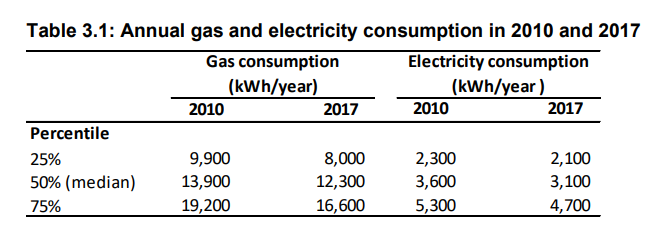

- Comparsion

the results of mean gas of entire dataset (5129 watt-hours) which is odd and much higher than benchmark (1626 watt-hours). the median value 2868 watt-hours ia also higher than benchmark (1404 watt-hours).

the result of mean electricity of entire dataset (372 watt-hours) is close to bechmark (375 watt-hours). the median value 327 watt-hours ia also close to benchmark (354 watt-hours). this seems to be reasonable.

- We see only gas value is odd, so we need to deal with it

# (2) Addressing Gas Usage Issues

Before addressing the issues with gas usage in the "energy use" dataset, we will make a copy of it and name this copy "original." 

This step ensures that the electricity data remains unaffected by the processes we apply to the gas usage data. 

After resolving the issues with gas data in the "energy use" dataset and obtaining reasonable gas data, we will use the "original" dataset again.

In [207]:
original = energy_use.copy() # take a copy 

# Detect the outliers of gas use

<Axes: >

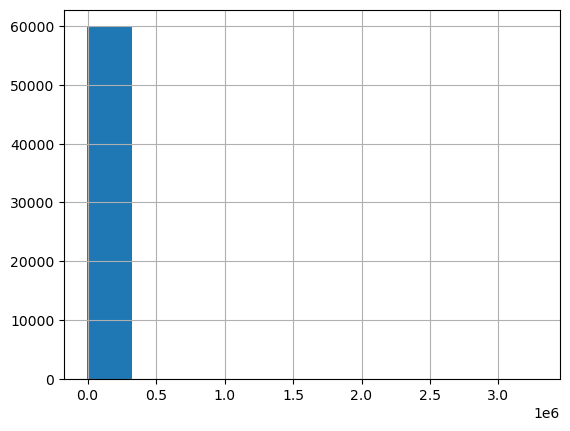

In [208]:
# continue deal with gas data on dataset "energy_use"

# check the distribution of gas_pulse
energy_use['mean_rounded_gas_pulse'].hist()

We've identified extremely obvious outliers in the gas usage data; for example, an average hourly gas consumption nearly 60,000 watt-hours in a day is impossible. 

We assume that by addressing these outliers, the average gas usage should align more closely with the benchmark values.

# Deal with extreme outliers

- We need to identify extremely high outliers in our gas usage data.
- It's important to account for winter conditions, where gas consumption can be significantly higher. Any daily values that exceed the highest average hourly gas use recorded in winter will be considered as extreme outliers.
- According to a 2017 BEIS report on energy consumption, daily gas usage varied widely during the EFUS heating season, ranging from 27 kWh/day in October to 64 kWh/day in January. This variation reflects the seasonal changes in gas usage.
- Based on this, we've set a threshold where daily gas usage should not exceed 64 kWh, equal to 6400 watt-hours.


Thus, any value exceeding 6400 will be classified as 'extreme_outliers'.

In [209]:
# when the value is higher than 6400, we set this value to be 'extreme_outliers'
energy_use['mean_rounded_gas_pulse'] = energy_use['mean_rounded_gas_pulse'].apply(lambda x: 'extreme_outliers' if x > 6400 else x )

# remove the rows with 'extreme_outliers', in order to not affect any other data (e.g. not affect exsited NaN)
energy_use = energy_use[energy_use['mean_rounded_gas_pulse'] != 'extreme_outliers']

- Setting Negative Values to Zero

This is a sensible approach as negative values for gas consumption are not possible and likely result from data entry errors or sensor malfunctions.

In [210]:
# check number of of negetive values
zero_gas_count = (energy_use['mean_rounded_gas_pulse'] < 0).sum()
print("Number of zero gas values:", zero_gas_count)

print('set negetive value to be 0')
energy_use['mean_rounded_gas_pulse'] = energy_use['mean_rounded_gas_pulse'].clip(lower=0)

Number of zero gas values: 1
set negetive value to be 0


# Check the results after remove extremly outliers of gas useage

In [211]:
# distribution of gas use after deal with outliers
energy_use[['mean_rounded_gas_pulse']].astype(float).describe()

,mean_rounded_gas_pulse
count,49468.000000
mean,2548.806845
std,1666.599693
min,0.000000
25%,1106.000000
50%,2291.000000
75%,3769.000000
max,6399.000000


- the results of mean gas of entire dataset (2548 watt-hours) which become more "reasonable" but still higher than benchmark (1626 watt-hours). the median value 2291 watt-hours ia also higher than benchmark (1404 watt-hours).

To further refine the data, we need to consider the instances where homes did not use gas on a particular day.

Previously, we assumed that values below 0 indicated no gas usage, and we adjusted them to 0. 

However, we must also consider how to handle NaN values. It's possible that NaN values represent days when gas was not used, and the sensors failed to record any data.

Therefore, we need to investigate the NaN values in the gas data to determine their significance and adjust accordingly.

# Deal with NaN value of gas use

- determine the days that residentis did not use gas.

In [212]:
# check the missing gas value of each month in raw dataset
missing_gas = energy_use.copy()
missing_gas = missing_gas.groupby(by=['year','month'])['mean_rounded_gas_pulse'].apply(lambda x: x.isnull().sum())
missing_gas

year  month
2016  8          36
      9          63
      10         45
      11        100
      12        125
2017  1         149
      2         117
      3         135
      4         209
      5         239
      6         400
      7         581
      8         539
      9         736
      10        758
      11        784
      12       1007
2018  1         953
      2         758
      3         920
      4        1072
      5        1203
      6         836
Name: mean_rounded_gas_pulse, dtype: int64

We've observed a significant number of missing values in the daily gas usage data in each month, which could explain why the average gas consumption consistently exceeds the benchmark. 

We have decided to interpret these NaN values as instances where no gas was used on that particular day. 

Therefore, we will set these NaN values to 0 rather than treating them as missing data. This approach should help provide a more accurate reflection of actual gas usage.

In [213]:
# set the missing gas value to 0
energy_use['mean_rounded_gas_pulse'] = energy_use['mean_rounded_gas_pulse'].fillna(0)

In [214]:
energy_use

,household_id,datetime,maxtemp,mintemp,conditions,day_of_week,is_weekend,is_bank_holiday,mean_rounded_gas_pulse,mean_rounded_electric_combined,year,month
0,100,2017-03-07,10.0,4.0,Chance of Rain,1.0,False,False,5277.0,343.0,2017,3
2,100,2017-03-09,11.0,3.0,Chance of Rain,3.0,False,False,1283.0,203.0,2017,3
3,100,2017-03-10,10.0,7.0,Overcast,4.0,False,False,4168.0,222.0,2017,3
4,100,2017-03-11,13.0,6.0,Chance of Rain,5.0,True,False,1264.0,243.0,2017,3
5,100,2017-03-12,11.0,4.0,Clear,6.0,True,False,3855.0,324.0,2017,3
...,...,...,...,...,...,...,...,...,...,...,...,...
71601,99,2018-06-26,16.0,11.0,Partly Cloudy,1.0,False,False,941.0,331.0,2018,6
71602,99,2018-06-27,22.0,12.0,Partly Cloudy,2.0,False,False,907.0,391.0,2018,6
71603,99,2018-06-28,28.0,11.0,Clear,3.0,False,False,702.0,360.0,2018,6
71604,99,2018-06-29,16.0,9.0,Partly Cloudy,4.0,False,False,895.0,500.0,2018,6


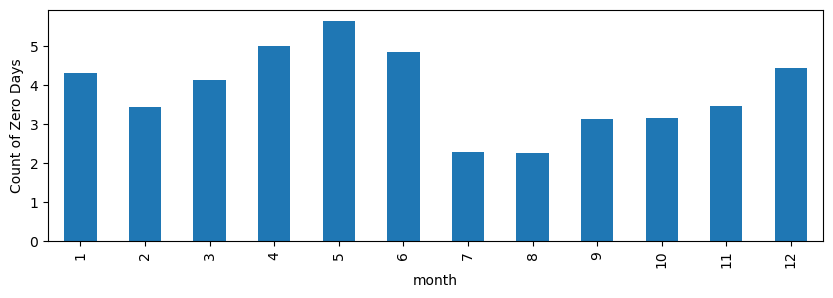

In [215]:
# check how many days that gas is 0 of average home in each month (if the gas is 0, it means the gas is not used in that particular day)
zero_gas  = energy_use[['datetime','mean_rounded_gas_pulse']].copy()
zero_gas = zero_gas[zero_gas['mean_rounded_gas_pulse'] == 0]
zero_gas['month'] = pd.to_datetime(zero_gas['datetime']).dt.month
zero_gas_count = zero_gas.groupby(by=['month']).size() / 255 #  average number of zero gas value of each home in each month
zero_gas_count.plot(kind='bar',figsize=(10, 3))
plt.ylabel('Count of Zero Days')
plt.show()

The results appear reasonable; on average, there may be days in each month when residents do not consume gas, potentially due to being on holiday or for other reasons.

# check gas distrubution after dealing NaN value of gas

In [216]:
# check result of gas
energy_use[['mean_rounded_gas_pulse']].describe()

,mean_rounded_gas_pulse
count,61233.000000
mean,2059.091944
std,1803.403717
min,0.000000
25%,434.000000
50%,1692.000000
75%,3371.000000
max,6399.000000


- the results of mean gas of entire dataset (2059 watt-hours) was decreased eventhough still higher than benchmark (1626 watt-hours). the median value 1629 watt-hours is close to benchmark (1404 watt-hours).

Text(0, 0.5, 'Gas use')

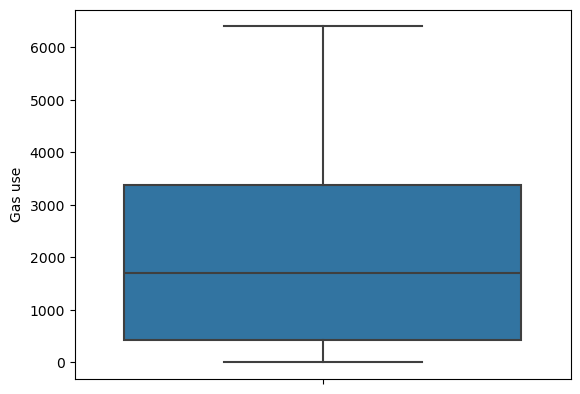

In [217]:
# using boxplot to check whether there are outliers under the principle of 1.5*IQR. Interquartile Range (IQR) Method

sns.boxplot(y=energy_use['mean_rounded_gas_pulse'])
plt.ylabel('Gas use')

- we can see that there are not outliers in gas now.

- In conclusion:

Although the average gas consumption (2,059 watt-hours) remains above the benchmark (1,626 watt-hours), the median value closely aligns with the benchmark. 

Therefore, we will retain these final results of gas.

# Integrate processed gas data back into main dataset

In [218]:
# integrate the column of processed gas data into the main dataset named 'original' which contains original electricity data.
original['mean_rounded_gas_pulse'] = energy_use['mean_rounded_gas_pulse']

In [219]:
# check the final result of "original" dataset
original[['mean_rounded_gas_pulse','mean_rounded_electric_combined']].describe()

,mean_rounded_gas_pulse,mean_rounded_electric_combined
count,61233.000000,66661.000000
mean,2059.091944,372.756754
std,1803.403717,228.590686
min,0.000000,0.000000
25%,434.000000,215.000000
50%,1692.000000,327.000000
75%,3371.000000,476.000000
max,6399.000000,5025.000000


<Axes: xlabel='month'>

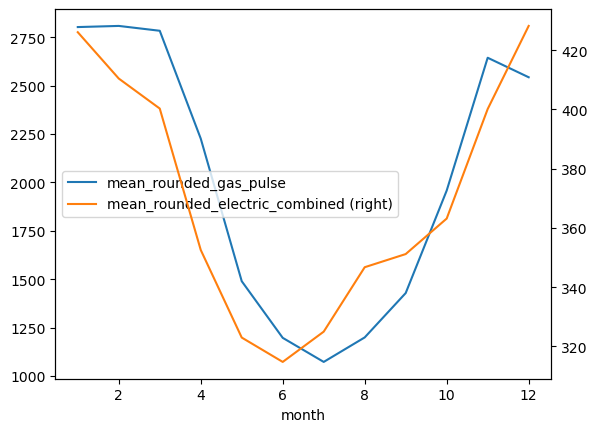

In [220]:
# check value of each month
monthly_energy = original.copy().groupby(by=['month'])[['mean_rounded_gas_pulse','mean_rounded_electric_combined']].mean()
monthly_energy.plot(secondary_y='mean_rounded_electric_combined')

In [221]:
# rename the column name of "household_id" to "homeid" for furthur use
original.rename(columns={'household_id':'homeid'}, inplace=True)
original

,homeid,datetime,maxtemp,mintemp,conditions,day_of_week,is_weekend,is_bank_holiday,mean_rounded_gas_pulse,mean_rounded_electric_combined,year,month
0,100,2017-03-07,10.0,4.0,Chance of Rain,1.0,False,False,5277.0,343.0,2017,3
1,100,2017-03-08,11.0,5.0,Chance of Rain,2.0,False,False,NaN,253.0,2017,3
2,100,2017-03-09,11.0,3.0,Chance of Rain,3.0,False,False,1283.0,203.0,2017,3
3,100,2017-03-10,10.0,7.0,Overcast,4.0,False,False,4168.0,222.0,2017,3
4,100,2017-03-11,13.0,6.0,Chance of Rain,5.0,True,False,1264.0,243.0,2017,3
...,...,...,...,...,...,...,...,...,...,...,...,...
71601,99,2018-06-26,16.0,11.0,Partly Cloudy,1.0,False,False,941.0,331.0,2018,6
71602,99,2018-06-27,22.0,12.0,Partly Cloudy,2.0,False,False,907.0,391.0,2018,6
71603,99,2018-06-28,28.0,11.0,Clear,3.0,False,False,702.0,360.0,2018,6
71604,99,2018-06-29,16.0,9.0,Partly Cloudy,4.0,False,False,895.0,500.0,2018,6


Now, we have successfully completed the preprocessing of the raw gas and electricity data. Save the this dataset after deal with outliers to furthur use.

In [222]:
# save the final dataset to "energy_use.csv"
original.to_csv('daily_energy_use_after_processing_outliers.csv', index=False)

# (3) Managing Missing Dates and Data in the "Original" Dataset

- Dealing with the missing value during the period of min max datetime

In [156]:
# load the final dataset
energy_use = pd.read_csv('daily_energy_use_after_processing_outliers.csv')
energy_use = original.copy()

In [157]:
# check how many data should be in period
print('start date:', energy_use['datetime'].min())
print('end date:', energy_use['datetime'].max())

days = energy_use['datetime'].unique()
print('total days:', len(days))

homes = energy_use['homeid'].unique()
print('total homes:', len(homes))

total_rows = len(days) * len(homes)

print('total rows should be:', total_rows)
print('but actual total rows:', len(energy_use))

start date: 2016-08-10 00:00:00
end date: 2018-06-30 00:00:00
total days: 690
total homes: 255
total rows shold be: 175950
but actual total rows: 71606


we can see that there should have 175950 datapoints during the period, but in fact, only 71606 are exsited.

# Generate dataset that have completed period of datetime


In [158]:
# generate a new dataframe with all the days in the period and all the households
# this will allow us to fill in missing values

# get all the days in the period
all_days = pd.date_range(start=energy_use['datetime'].min(), end=energy_use['datetime'].max(), freq='D')
print('number of days:', all_days.shape)

# get all the households
all_houses = energy_use['homeid'].unique()
print('number of households:', all_houses.shape)

# create a new dataframe with all the days and all the households, set index to homeid
all_combinations = pd.MultiIndex.from_product([all_houses, all_days], names=['homeid','datetime'])
all_combinations = pd.DataFrame(index=all_combinations).reset_index()
all_combinations.shape

number of days: (690,)
number of households: (255,)


(175950, 2)

In [159]:
# Now merge the all_combinations with the original energy use data
complete_data = pd.merge(all_combinations, energy_use, how='left', on=['homeid','datetime'])
complete_data.shape

(175950, 12)

In [160]:
complete_data['year'] = complete_data['datetime'].dt.year
complete_data['month'] = complete_data['datetime'].dt.month
complete_data['day_of_week'] = complete_data['datetime'].dt.dayofweek

# check for missing values
complete_data.isnull().sum()

homeid                                 0
datetime                               0
maxtemp                           116511
mintemp                           116511
conditions                        116511
day_of_week                            0
is_weekend                        116511
is_bank_holiday                   116511
mean_rounded_gas_pulse            114717
mean_rounded_electric_combined    109289
year                                   0
month                                  0
dtype: int64

In [161]:
# remove the columns that have missing value, and are not needed
complete_data.drop(columns=['maxtemp','mintemp','is_weekend','is_bank_holiday','conditions'], inplace=True)

In [162]:
# check average of gas_pulse and electric_combined for each month in complete_data
monthly_energy = complete_data.groupby(by=['month'])[['mean_rounded_gas_pulse','mean_rounded_electric_combined']].mean()
monthly_energy


,mean_rounded_gas_pulse,mean_rounded_electric_combined
month,,
1,2802.349735,426.068660
2,2808.252189,410.420634
3,2783.226742,400.290306
4,2226.393906,352.550013
5,1489.971386,322.973836
6,1197.452728,314.749609
7,1073.133249,324.970523
8,1199.690976,346.724219
9,1428.774280,351.165017


# divded data into 12 dataframes by their months
rather than impute data on overall dataset, it is better to deal with the missing value individually by each months. 

so firstly we need to divided dataset by each month, then using KNN method to impute missing values

In [163]:
# divided complete_data into 12 individual dataframes by each month
months = [complete_data[complete_data['month'] == i] for i in range(1, 13)]

# check data for month 1
months[0].head()


,homeid,datetime,day_of_week,mean_rounded_gas_pulse,mean_rounded_electric_combined,year,month
144,100,2017-01-01,6,NaN,NaN,2017,1
145,100,2017-01-02,0,NaN,NaN,2017,1
146,100,2017-01-03,1,NaN,NaN,2017,1
147,100,2017-01-04,2,NaN,NaN,2017,1
148,100,2017-01-05,3,NaN,NaN,2017,1


In [164]:
# validation, check the length of each month, and the sum of length should be equal to the length of complete_data 175950

# check each month's length, and the sum of length should be equal to the length of complete_data
print('length of each month:')
for i, month in enumerate(months):
    print('month', i+1, ':', len(month))

print('total length of all months:', sum([len(month) for month in months]))

length of each month:
month 1 : 15810
month 2 : 14280
month 3 : 15810
month 4 : 15300
month 5 : 15810
month 6 : 15300
month 7 : 7905
month 8 : 13515
month 9 : 15300
month 10 : 15810
month 11 : 15300
month 12 : 15810
total length of all months: 175950


# (4) Data imputation by each month

we intended to use KNN method to impute missing data.
 

we need addtional data such as 'hometype'


In [165]:
# find home type data
home_type = pd.read_csv('../data/home.csv')
home_type = home_type[['homeid', 'hometype']]

In [166]:
# merge home_type with each month data
for i, month in enumerate(months):
    months[i] = pd.merge(month, home_type, how='left', on='homeid')

# check data for month 1
months[0].head()

,homeid,datetime,day_of_week,mean_rounded_gas_pulse,mean_rounded_electric_combined,year,month,hometype
0,100,2017-01-01,6,NaN,NaN,2017,1,flat
1,100,2017-01-02,0,NaN,NaN,2017,1,flat
2,100,2017-01-03,1,NaN,NaN,2017,1,flat
3,100,2017-01-04,2,NaN,NaN,2017,1,flat
4,100,2017-01-05,3,NaN,NaN,2017,1,flat


# Multiple Imputation for daily gas and electricity  missing data of each "month" dataframe

In [167]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import LabelEncoder

In [168]:
# define a function for encoding categorical features

def encode_categorical_features(df, column_names):
    label_encoder = LabelEncoder()
    for column in column_names:
        # Check if the column is in the DataFrame and is categorical
        if column in df.columns and df[column].dtype == 'object':
            # Convert to string type in case of mixed types
            df[column] = label_encoder.fit_transform(df[column].astype(str))
        else:
            # no need to encode
            pass
    return df

In [169]:
# apply the function to each month's dataframe
for i in range(12):  # assming dataframes indexed from 0 to 11
    column_names = list(months[i].columns)
    months[i] = encode_categorical_features(months[i], column_names) 

In [170]:
# check the dataframes of month 1
months[0].head()

,homeid,datetime,day_of_week,mean_rounded_gas_pulse,mean_rounded_electric_combined,year,month,hometype
0,100,2017-01-01,6,NaN,NaN,2017,1,0
1,100,2017-01-02,0,NaN,NaN,2017,1,0
2,100,2017-01-03,1,NaN,NaN,2017,1,0
3,100,2017-01-04,2,NaN,NaN,2017,1,0
4,100,2017-01-05,3,NaN,NaN,2017,1,0


In [171]:
months[0].isnull().sum()

homeid                                0
datetime                              0
day_of_week                           0
mean_rounded_gas_pulse            10709
mean_rounded_electric_combined     9489
year                                  0
month                                 0
hometype                              0
dtype: int64

# Imputation process

- KNN method

KNN Imputation uses the k-nearest neighbors to impute missing values. The imputation is done based on the mean or median (or any other aggregate) of the k-nearest neighbors found in the training set. Each feature's missing value is imputed using the non-missing values that are closest to that record in Euclidean space.

In [172]:
from sklearn.impute import KNNImputer

#  'months' is a list containing each month's DataFrame
# [month_1, month_2, ..., month_12]

# Define the columns to impute
columns_to_impute = ['mean_rounded_gas_pulse', 'mean_rounded_electric_combined']

# Create an imputer object with a specific number of neighbors
imputer = KNNImputer(n_neighbors=10, weights="distance")

# Loop through each DataFrame in the list
for i in range(len(months)):
    # Select only the columns that need imputation to avoid fitting the imputer to unnecessary data
    df_subset = months[i][columns_to_impute]
    
    # Apply fit_transform to the subset and then assign the imputed data back to the original DataFrame
    months[i][columns_to_impute] = imputer.fit_transform(df_subset)
    
    # Optional: Output to check progress
    print(f"Imputation completed for Month {i+1}")


Imputation completed for Month 1
Imputation completed for Month 2
Imputation completed for Month 3
Imputation completed for Month 4
Imputation completed for Month 5
Imputation completed for Month 6
Imputation completed for Month 7
Imputation completed for Month 8
Imputation completed for Month 9
Imputation completed for Month 10
Imputation completed for Month 11
Imputation completed for Month 12


In [173]:
# check average of gas_pulse and electric_combined for each month
average_monthly_energy = [month[['mean_rounded_gas_pulse', 'mean_rounded_electric_combined']].mean() for month in months]
average_monthly_energy = pd.DataFrame(average_monthly_energy, index=range(1,13))
average_monthly_energy


,mean_rounded_gas_pulse,mean_rounded_electric_combined
1,2849.729822,421.714755
2,2842.892139,403.433931
3,2825.919851,401.361032
4,2252.101329,348.847937
5,1496.318092,322.438735
6,1198.591232,322.828625
7,1074.473567,325.186205
8,1200.490412,346.717329
9,1432.922245,349.738826
10,1965.249360,360.489092


In [174]:
# check the imputation result of dataframes of month 1
months[0].isnull().sum()

homeid                            0
datetime                          0
day_of_week                       0
mean_rounded_gas_pulse            0
mean_rounded_electric_combined    0
year                              0
month                             0
hometype                          0
dtype: int64

now the imputation work is finished for each of "months" data

In [175]:
# combine all the 12 dataframes into one
complete_data_imputed = pd.concat(months, ignore_index=True)
complete_data_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175950 entries, 0 to 175949
Data columns (total 8 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   homeid                          175950 non-null  int64         
 1   datetime                        175950 non-null  datetime64[ns]
 2   day_of_week                     175950 non-null  int32         
 3   mean_rounded_gas_pulse          175950 non-null  float64       
 4   mean_rounded_electric_combined  175950 non-null  float64       
 5   year                            175950 non-null  int32         
 6   month                           175950 non-null  int32         
 7   hometype                        175950 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(4), int64(1)
memory usage: 8.1 MB


we have finished imputation work for each months, and get a completed dataframe

In [176]:
# check the date range of the complete_data_imputed
# check time period
print('start date:', complete_data_imputed['datetime'].min())
print('end date:', complete_data_imputed['datetime'].max())

days = complete_data_imputed['datetime'].unique()
print('total days:', len(days))

homes = complete_data_imputed['homeid'].unique()
print('total homes:', len(homes))

total_rows = len(days) * len(homes)

print('total rows shold be:', total_rows)
print('actual total rows:', len(complete_data_imputed))

start date: 2016-08-10 00:00:00
end date: 2018-06-30 00:00:00
total days: 690
total homes: 255
total rows shold be: 175950
actual total rows: 175950


In [223]:
# validate the imputation result

# check the distribution of imputed result
complete_data_imputed[['mean_rounded_gas_pulse','mean_rounded_electric_combined']].describe()

,mean_rounded_gas_pulse,mean_rounded_electric_combined
count,175950.000000,175950.000000
mean,2082.306677,371.060186
std,1222.129548,145.473819
min,0.000000,0.000000
25%,1199.690976,322.973836
50%,1958.040100,352.550013
75%,2783.226742,410.420634
max,6399.000000,5025.000000


In [224]:
# check the distribution before imputation
original[['mean_rounded_gas_pulse','mean_rounded_electric_combined']].describe()

,mean_rounded_gas_pulse,mean_rounded_electric_combined
count,61233.000000,66661.000000
mean,2059.091944,372.756754
std,1803.403717,228.590686
min,0.000000,0.000000
25%,434.000000,215.000000
50%,1692.000000,327.000000
75%,3371.000000,476.000000
max,6399.000000,5025.000000


we can see that the mean, medain of both gas and electricity are similar before and after imputation, which means the imputation is successful.

# Select a full year data for calculate energy expenditure

we need select a whole year 365 data points, because we calculate energy poverty by annual income.

In [177]:
# check which period of a whole year 365 days, that most of homes have most of gas_pulse and electric_combined , have most no nan values

original_data = complete_data.copy()

# Group by year and month, and then apply a custom aggregation to count non-NaN entries
monthly_data_availability = original_data.groupby(['year', 'month']).apply(lambda df: df[['mean_rounded_gas_pulse', 'mean_rounded_electric_combined']].notna().sum()).reset_index()

# Rename columns for clarity
monthly_data_availability.columns = ['year', 'month', 'non_nan_gas', 'non_nan_electric']
monthly_data_availability

,year,month,non_nan_gas,non_nan_electric
0,2016,8,36,36
1,2016,9,90,90
2,2016,10,163,162
3,2016,11,307,249
4,2016,12,400,379
5,2017,1,559,572
6,2017,2,809,913
7,2017,3,1100,1268
8,2017,4,1228,1289
9,2017,5,1337,1328


we can see the period from 2017-6 to 2018-6 have most non nan values, which means they have most of non imputed data, so this period is ideal to use.

then we will select the data in comleted imputed dataset from period from 2017-7 to 2018-6, total 12 months

In [178]:
# we need to select a whole year of data, because when calculate energy poverty, the income is annual one.

data_select = complete_data_imputed[(complete_data_imputed['datetime'] >= '2017-07-01') & (complete_data_imputed['datetime'] < '2018-07-1')]

In [179]:
# check the date range of data_select
print('start date:', data_select['datetime'].min())
print('end date:', data_select['datetime'].max())

days = data_select['datetime'].unique()
print('total days:', len(days))

homes = data_select['homeid'].unique()
print('total homes:', len(homes))

total_rows = len(days) * len(homes)

print('total rows shold be:', total_rows)
print('actual total rows:', len(data_select))

start date: 2017-07-01 00:00:00
end date: 2018-06-30 00:00:00
total days: 365
total homes: 255
total rows shold be: 93075
actual total rows: 93075


In [180]:
data_select.to_csv('../Lin_EP_test/daily_energy_demand_imputation.csv', index=False)

<Axes: title={'center': 'Average hourly gas and electric each month'}, xlabel='month'>

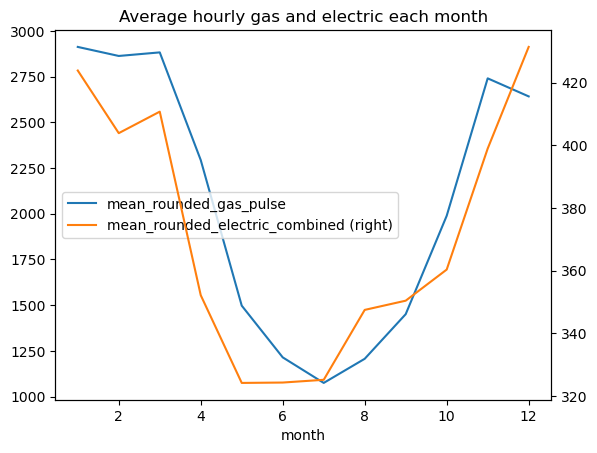

In [181]:
# now plot average montly gas_pulse and electric_combined for all households
# put the gas_pulse on the left y-axis and the electric_combined on the right y-axis
month = data_select.copy()
month['month'] = month['datetime'].dt.month
grouped = month.groupby(by='month')[['mean_rounded_gas_pulse','mean_rounded_electric_combined']].mean()
grouped.plot(secondary_y='mean_rounded_electric_combined', title='Average hourly gas and electric each month')

<Axes: title={'center': 'Average hourly gas and electric for datetime_range'}, xlabel='date'>

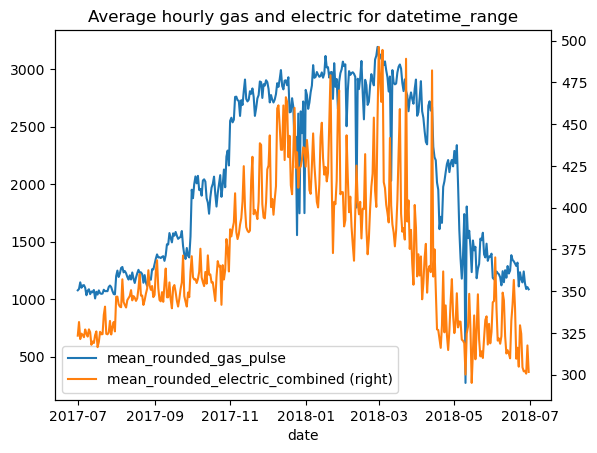

In [182]:
# now plot average daily gas_pulse and electric_combined for all households, put the gas_pulse on the left y-axis and the electric_combined on the right y-axis
datetime_range = data_select.copy()
datetime_range['date'] = datetime_range['datetime'].dt.date
grouped = datetime_range.groupby(by='date')[['mean_rounded_gas_pulse','mean_rounded_electric_combined']].mean()
grouped.plot(secondary_y='mean_rounded_electric_combined', title='Average hourly gas and electric for datetime_range')

<Axes: title={'center': 'Average hourly total energy for each season'}, xlabel='season'>

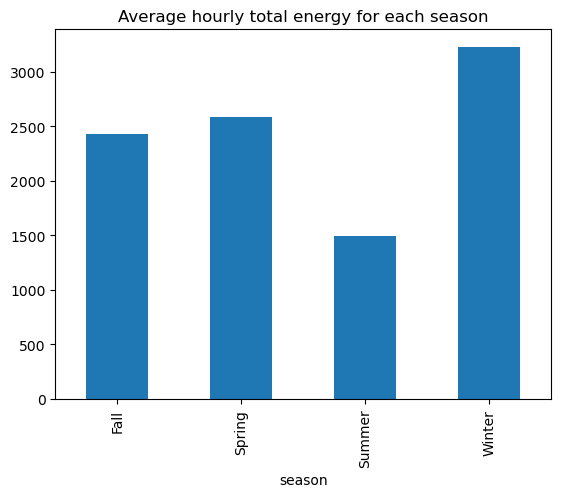

In [183]:
# now plot average daily gas_pulse and electric_combined for each season for all households
season = data_select.copy()
season['energy'] = season['mean_rounded_electric_combined'] + season['mean_rounded_gas_pulse']
season['season'] = season['datetime'].dt.month % 12 // 3
season['season'] = season['season'].map({0:'Winter', 1:'Spring', 2:'Summer', 3:'Fall'})
grouped = season.groupby(by='season')['energy'].mean()
grouped.plot( title='Average hourly total energy for each season', kind='bar')



In [184]:
data_select

,homeid,datetime,day_of_week,mean_rounded_gas_pulse,mean_rounded_electric_combined,year,month,hometype
31,100,2018-01-01,0,2098.166667,456.0,2018,1,0
32,100,2018-01-02,1,3761.500000,239.0,2018,1,0
33,100,2018-01-03,2,3344.000000,324.0,2018,1,0
34,100,2018-01-04,3,3133.000000,201.0,2018,1,0
35,100,2018-01-05,4,3208.300000,225.0,2018,1,0
...,...,...,...,...,...,...,...,...
175945,99,2017-12-27,2,1758.000000,1316.0,2017,12,1
175946,99,2017-12-28,3,3188.285714,494.0,2017,12,1
175947,99,2017-12-29,4,5374.000000,855.0,2017,12,1
175948,99,2017-12-30,5,3590.200000,614.0,2017,12,1


In [188]:
# average of gas_pulse and electric_combined for all selected dataset
data_select[['mean_rounded_gas_pulse','mean_rounded_electric_combined']].describe()

,mean_rounded_gas_pulse,mean_rounded_electric_combined
count,93075.000000,93075.000000
mean,2059.067813,370.986920
std,1504.171316,189.272345
min,0.000000,0.000000
25%,1073.133249,272.000000
50%,1839.000000,346.724219
75%,2808.252189,426.068660
max,6399.000000,5025.000000


# Conclusion

- seleted dataset (with imputed missing data)

 mean: Gas: 2059 ; Electricity: 370.
 medain: Gas: 1839; Electricity: 347.


- original: 

 mean: Gas: 2059 ; Electricity: 370.
 medain: Gas: 1839; Electricity: 347.


- benchmark: 

 mean: Gas: 1626 ; Electricity: 375.
 medain: Gas: 1440; Electricity: 354.

- conclusion

the seleted dataset (with imputed data), which contain daily average hourly gas use and electricity use of 255 homes from 2017-07-01 to 2018-06-30 (total 12 months) keep the same distrubution to original dataset (raw data after processing). 

so we can use this full one year full dataset to do furthur analysis, e.g. to calculate the energy expenditure and energy poverty.


In [193]:
# save the final selected dataset to "daily_energy_demand_imputation.csv"
data_select.to_csv('../Lin_EP_test/daily_energy_demand_imputation.csv', index=False)

# Average value divided by home type

In [191]:
# check average value by different home type

energy_use_by_home_type = data_select[['hometype','mean_rounded_gas_pulse','mean_rounded_electric_combined','datetime']]

In [192]:
result = energy_use_by_home_type.groupby('hometype').mean()
result

,mean_rounded_gas_pulse,mean_rounded_electric_combined,datetime
hometype,,,
0,1965.452959,337.619783,2017-12-30
1,2180.514109,414.274016,2017-12-30


we can see that the average result of house is higher than flat.

In [230]:
data_select

,homeid,datetime,day_of_week,mean_rounded_gas_pulse,mean_rounded_electric_combined,year,month,hometype
31,100,2018-01-01,0,2098.166667,456.0,2018,1,0
32,100,2018-01-02,1,3761.500000,239.0,2018,1,0
33,100,2018-01-03,2,3344.000000,324.0,2018,1,0
34,100,2018-01-04,3,3133.000000,201.0,2018,1,0
35,100,2018-01-05,4,3208.300000,225.0,2018,1,0
...,...,...,...,...,...,...,...,...
175945,99,2017-12-27,2,1758.000000,1316.0,2017,12,1
175946,99,2017-12-28,3,3188.285714,494.0,2017,12,1
175947,99,2017-12-29,4,5374.000000,855.0,2017,12,1
175948,99,2017-12-30,5,3590.200000,614.0,2017,12,1


In [233]:
# calculate annual energy consumption for each home
annual_electric = data_select[['homeid','mean_rounded_electric_combined']].groupby('homeid').sum() * 24 / 1000
annual_electric = annual_electric.reset_index()
annual_gas = data_select[['homeid','mean_rounded_gas_pulse']].groupby('homeid').sum() *24 / 1000
annual_gas = annual_gas.reset_index()
annual_energy = pd.merge(annual_electric, annual_gas, on='homeid', how='inner')
annual_energy.rename(columns={'mean_rounded_electric_combined':'annual_electric_kWh', 'mean_rounded_gas_pulse':'annual_gas_kWh'}, inplace=True)
annual_energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255 entries, 0 to 254
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   homeid               255 non-null    int64  
 1   annual_electric_kWh  255 non-null    float64
 2   annual_gas_kWh       255 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 6.1 KB


In [234]:
annual_energy.describe()
print("Energy consumption results of 255 homes")
print("mean gas_kWh is ", round(annual_energy['annual_gas_kWh'].mean(),2), "kWh")
print("mean annual_electric_kWh is ", round(annual_energy['annual_electric_kWh'].mean(),2), "kWh")

Energy consumption results of 255 homes
mean gas_kWh is  18037.43 kWh
mean annual_electric_kWh is  3249.85 kWh


this results is similar to NEED4 (which also uses meter point data) where in 2017 the median gas consumption was 12,300 kWh/year (LQ 8,300 kWh/year; UQ 17,100 kWh/year)
and the median electricity consumption 3,100 kWh/year (LQ 2,000 kWh/year; UQ 4,700 kWh/year).

reference:https://assets.publishing.service.gov.uk/media/61449c45e90e07044435c9e7/efus-Household-Energy-Consumption-Affordability.pdf